In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

In [139]:
df_real = pd.read_csv('../data/solana.csv')
df_real['Date'] = pd.to_datetime(df_real['Date'], format='%Y-%m-%d')
df_real.set_index('Date', inplace=True)

In [140]:
df_real = df_real[['Close']]

In [141]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_real)

In [142]:
def create_dateset(data, time_step=1):
    x, y = [], []

    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

In [143]:
time_step = 30
x, y = create_dateset(df_scaled, time_step)
x = x.reshape(x.shape[0], x.shape[1], 1)

In [144]:
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [145]:
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

In [146]:
from tensorflow.keras import backend as K
K.clear_session()

x_test = np.array(x_test).reshape((-1, 30, 1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0533
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.8514e-04
Epoch 13/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011  
Epoch 14/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9589e-04
Epoch 15/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0

In [147]:
y_pred=model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [148]:
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled) * 100
print(f"📊 MAPE: {mape:.2f}% between predict and real value of closed")

📊 MAPE: 9.03% between predict and real value of closed


In [149]:
last_data = df_scaled[-time_step:].reshape(1, time_step, 1)
predicted_next_day = model.predict(last_data)
predicted_next_day_rescaled = scaler.inverse_transform(predicted_next_day)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [150]:
predicted_day_df = pd.DataFrame({'Date': [df_real.index[-1] + pd.Timedelta(days=1)], 
                                 'Predicted': predicted_next_day_rescaled
                                 .flatten()})
predicted_day_df.to_csv('predict_day.csv', index=False)

In [151]:
df_forecast = pd.DataFrame(data={'Date': df_real.index[-len(y_test):], 'Real': y_test_rescaled.flatten(),
                                 'Predicted': y_pred_rescaled
                                 .flatten()})
df_forecast.to_csv('forecast_solana.csv', index=False)

In [152]:
df_real['MA7'] = df_real['Close'].rolling(window=7).mean()
df_real['MA20'] = df_real['Close'].rolling(window=20).mean()

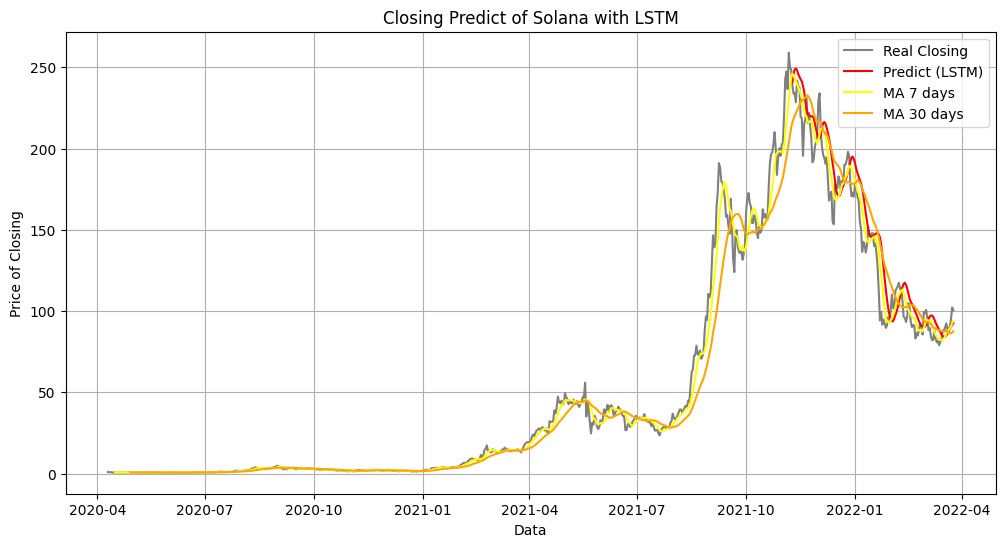

In [153]:
plt.figure(figsize=(12, 6))
plt.plot(df_real.index, df_real['Close'], label='Real Closing', color='gray')
plt.plot(df_forecast['Date'], df_forecast['Predicted'], label='Predict (LSTM)', color='red')

plt.plot(df_real.index, df_real['MA7'], label='MA 7 days', color='yellow')
plt.plot(df_real.index, df_real['MA20'], label='MA 30 days', color='orange')

plt.title('Closing Predict of Solana with LSTM')
plt.xlabel('Data')
plt.ylabel('Price of Closing')
plt.legend()
plt.grid(True)

plt.show()